In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =5e-25

nband = 80

ng =5

ng_refs = (/ 5 /) 

nref =1

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

tsfc =257

vstar = 720

data w_diffuse
     &     /1.55 , 1.6 , 1.66 , 1.66,
     &     1.8/

data wgt
     &     /0.5 , 0.5 , 0.6 , 0.7,
     &     0.9/

atmosphere_profiles/saw75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

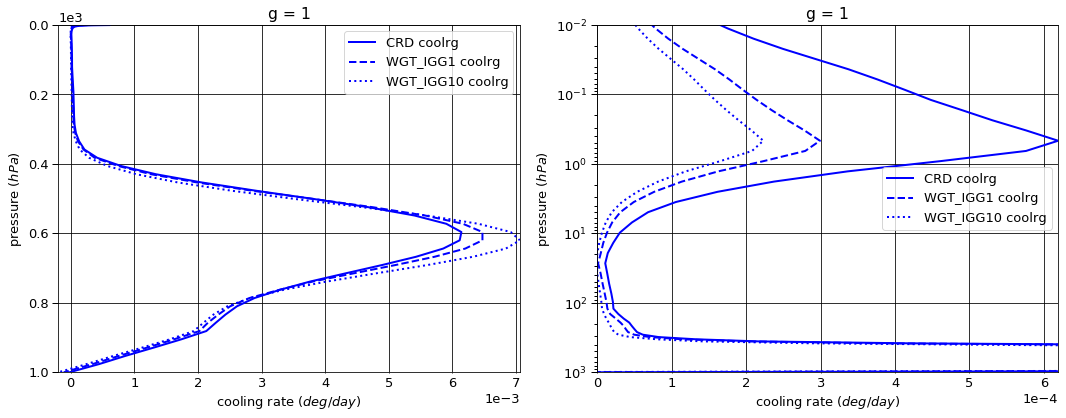

# Figure: cooling rate g-group 2

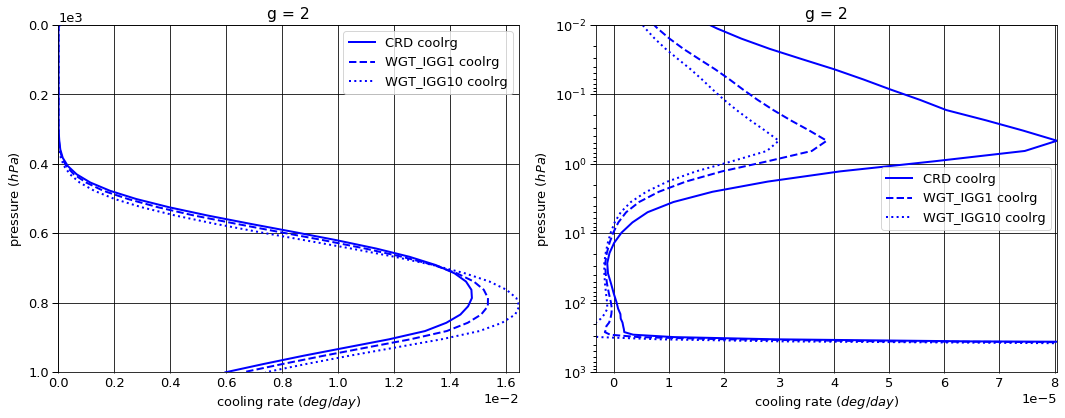

# Figure: cooling rate g-group 3

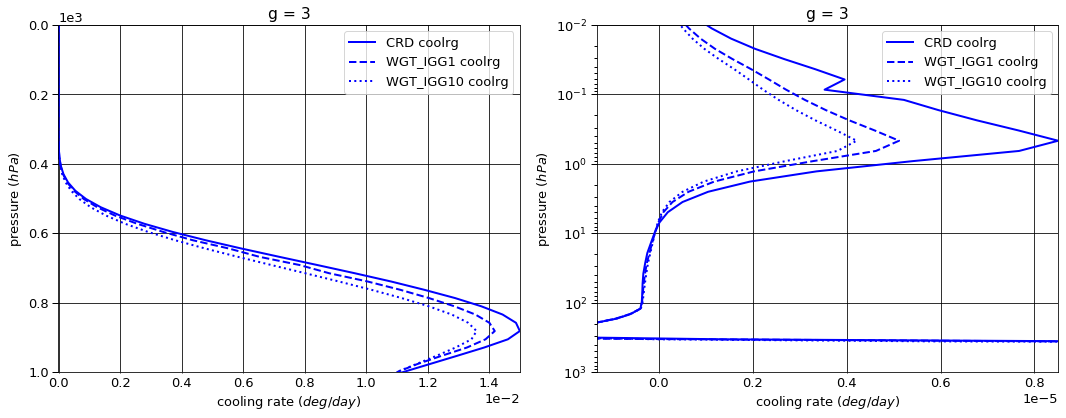

# Figure: cooling rate g-group 4

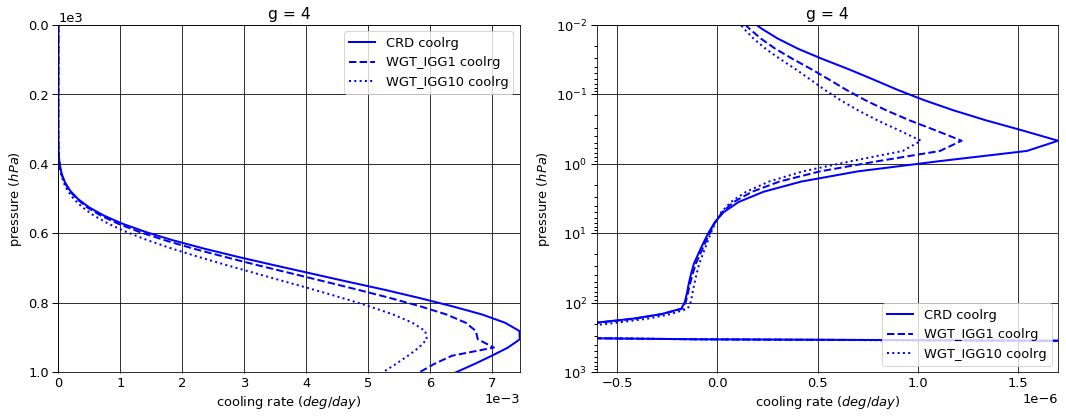

# Figure: cooling rate g-group 5

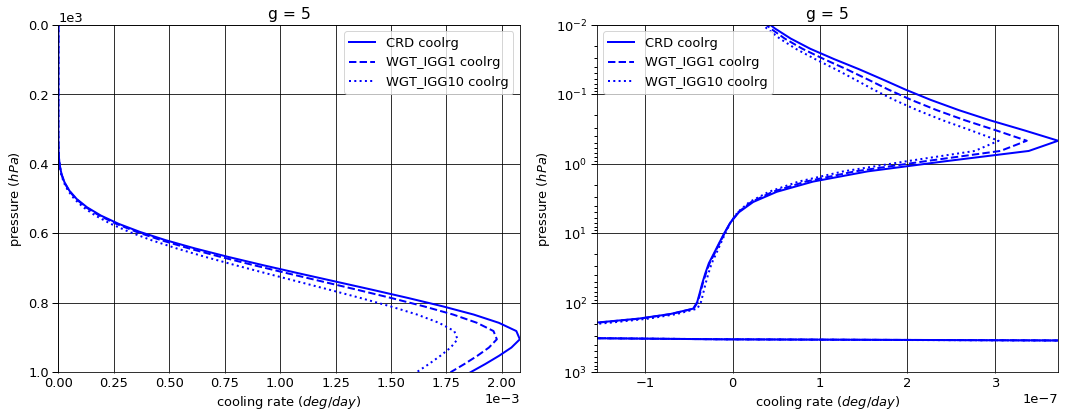

# Figure: cooling rate g-group total

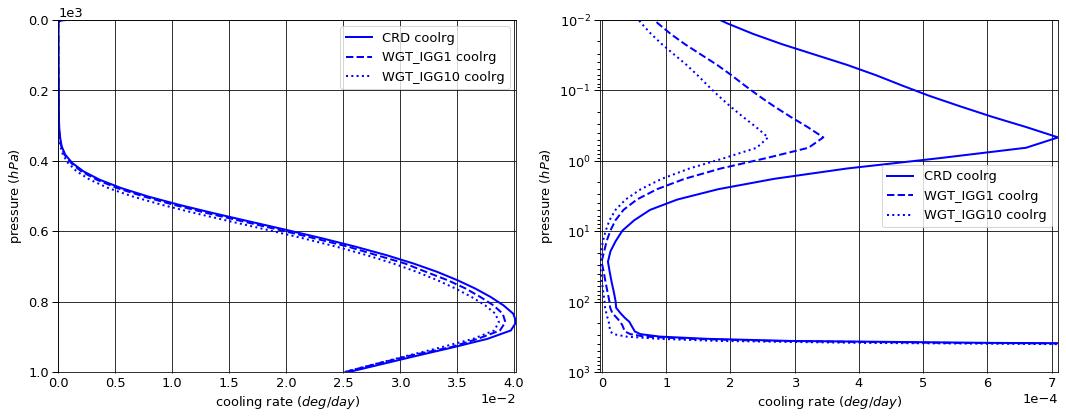

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.238006  0.000000 -0.238006
  1013.0   76    -0.291872  0.292602  0.000730
2 0.0      1     -0.924107  0.000000 -0.924107
  1013.0   76    -0.977821  0.722540 -0.255282
3 0.0      1     -2.403019  0.000000 -2.403019
  1013.0   76    -2.422263  0.599930 -1.822333
4 0.0      1     -5.464507  0.000000 -5.464507
  1013.0   76    -5.471011  0.280839 -5.190172
5 0.0      1     -9.756922  0.000000 -9.756922
  1013.0   76    -9.758556  0.077142 -9.681413


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.237939  0.000000 -0.237939
  1013.0   76    -0.291872  0.294521  0.002649
2 0.0      1     -0.927973  0.000000 -0.927973
  1013.0   76    -0.977821  0.729542 -0.248279
3 0.0      1     -2.404725  0.000000 -2.404725
  1013.0   76    -2.422263  0.564151 -1.858112
4 0.0      1     -5.464915  0.000000 -5.464915
  1013.0   76    -5.471011  0.258290 -5.212721
5 0.0      1     -9.756980  0.000000 -9.756980
  1013.0   76    -9.758556  0.073456 -9.685099


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.239676  0.000000 -0.239676
  1013.0   76    -0.291872  0.296063  0.004191
2 0.0      1     -0.933574  0.000000 -0.933574
  1013.0   76    -0.977821  0.742360 -0.235462
3 0.0      1     -2.407847  0.000000 -2.407847
  1013.0   76    -2.422263  0.526796 -1.895467
4 0.0      1     -5.466001  0.000000 -5.466001
  1013.0   76    -5.471011  0.222805 -5.248206
5 0.0      1     -9.757134  0.000000 -9.757134
  1013.0   76    -9.758556  0.066774 -9.691781


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      6.698000e-05  0.000000  0.000067
  1013.0   76     0.000000e+00  0.001919  0.001919
2 0.0      1     -3.865680e-03  0.000000 -0.003866
  1013.0   76     0.000000e+00  0.007003  0.007003
3 0.0      1     -1.706200e-03  0.000000 -0.001706
  1013.0   76     0.000000e+00 -0.035779 -0.035779
4 0.0      1     -4.077000e-04  0.000000 -0.000408
  1013.0   76     0.000000e+00 -0.022549 -0.022549
5 0.0      1     -5.760000e-05  0.000000 -0.000058
  1013.0   76     1.776357e-15 -0.003686 -0.003686


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -1.670080e-03  0.000000 -0.001670
  1013.0   76     0.000000e+00  0.003461  0.003461
2 0.0      1     -9.466580e-03  0.000000 -0.009467
  1013.0   76     0.000000e+00  0.019820  0.019820
3 0.0      1     -4.827800e-03  0.000000 -0.004828
  1013.0   76     0.000000e+00 -0.073134 -0.073135
4 0.0      1     -1.493200e-03  0.000000 -0.001493
  1013.0   76     0.000000e+00 -0.058034 -0.058034
5 0.0      1     -2.121000e-04  0.000000 -0.000212
  1013.0   76     1.776357e-15 -0.010368 -0.010368

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      1.686268e-05
  1001.112500 75    -2.006416e-05
2 0.000312    1     -1.056296e-06
  1001.112500 75     5.972822e-03
3 0.000312    1     -1.893085e-07
  1001.112500 75     1.117997e-02
4 0.000312    1     -7.040379e-08
  1001.112500 75     6.415512e-03
5 0.000312    1     -1.320897e-08
  1001.112500 75     1.858380e-03


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      1.665707e-06
  1001.112500 75    -1.098791e-04
2 0.000312    1     -1.592338e-06
  1001.112500 75     6.605390e-03
3 0.000312    1     -1.418103e-07
  1001.112500 75     1.099166e-02
4 0.000312    1     -4.959367e-08
  1001.112500 75     5.825302e-03
5 0.000312    1     -1.239241e-08
  1001.112500 75     1.768375e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -2.201877e-06
  1001.112500 75    -1.940524e-04
2 0.000312    1     -1.684026e-06
  1001.112500 75     7.401248e-03
3 0.000312    1     -1.266200e-07
  1001.112500 75     1.097265e-02
4 0.000312    1     -4.158423e-08
  1001.112500 75     5.236882e-03
5 0.000312    1     -1.126365e-08
  1001.112500 75     1.615120e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.519698e-05
  1001.112500 75    -8.981493e-05
2 0.000312    1     -5.360424e-07
  1001.112500 75     6.325675e-04
3 0.000312    1      4.749824e-08
  1001.112500 75    -1.883100e-04
4 0.000312    1      2.081013e-08
  1001.112500 75    -5.902109e-04
5 0.000312    1      8.165540e-10
  1001.112500 75    -9.000500e-05


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.906456e-05
  1001.112500 75    -1.739882e-04
2 0.000312    1     -6.277306e-07
  1001.112500 75     1.428426e-03
3 0.000312    1      6.268855e-08
  1001.112500 75    -2.073230e-04
4 0.000312    1      2.881956e-08
  1001.112500 75    -1.178630e-03
5 0.000312    1      1.945321e-09
  1001.112500 75    -2.432598e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-18.786561,0.000000,-18.786561
1013.0,76,-18.921523,1.973053,-16.948469



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-18.792531,0.000000,-18.792531
1013.0,76,-18.921523,1.919961,-17.001562



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-18.804231,0.000000,-18.804231
1013.0,76,-18.921523,1.854798,-17.066725



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.00597,0.000000,-0.005970
1013.0,76,0.00000,-0.053093,-0.053093



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.01767,0.000000,-0.017670
1013.0,76,0.00000,-0.118256,-0.118256


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.000016
1001.112500,75,0.025407



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-1.304277e-07
1001.112500,75,2.508085e-02



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000004
1001.112500,75,0.025032



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000016
1001.112500,75,-0.000326



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000020
1001.112500,75,-0.000375


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.015500,0.015423
2,0.052000,0.051652
3,0.128688,0.127952
4,0.290063,0.289068
5,0.513750,0.515905


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.501949e-22
2,2.243039e-23
3,3.349798e-24
4,5.002654e-25
5,3.765264e-26


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.501949e-22,NaN,0.015500,0.015423,0.015500,0.015423,600.0
2,2.243039e-23,0.149342,0.052000,0.051652,0.067500,0.067075,600.0
3,3.349798e-24,0.149342,0.128688,0.127952,0.196188,0.195027,600.0
4,5.002654e-25,0.149342,0.290063,0.289068,0.486250,0.484095,600.0
5,3.765264e-26,0.075265,0.513750,0.515905,1.000000,1.000000,600.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     2.421241e-22  7.781948e-24  31.113566  1.064115e-08
      2 0.000312     1.083513e-23  2.666052e-25  40.641114  4.727183e-10
      3 0.000312     2.105735e-25  1.423649e-26  14.791111  1.124457e-11
      4 0.000312     2.571843e-26  2.812653e-27   9.143833  1.605006e-12
      5 0.000312     2.935720e-27  1.713668e-28  17.131210  2.264677e-13
2     1 0.000750     2.501274e-22  7.859925e-24  31.823122  4.424711e-09
      2 0.000750     1.111022e-23  2.712374e-25  40.961225  1.952020e-10
      3 0.000750     2.228671e-25  1.439200e-26  15.485479  4.784310e-12
      4 0.000750     2.682013e-26  2.875994e-27   9.325518  6.735802e-13
      5 0.000750     3.072276e-27  1.750793e-28  17.547906  9.544661e-14
3     1 0.001052     2.670595e-22  8.010998e-24  33.336613  6.616040e-09
      2 0.001052     1.169948e-23  2.807970e-25  41.665247  2.881515e-10
      3 0.001052     2.500119e-25  1.466564e-26  17.047461  7.498182e-12
      4 0.001052     2.921180e-26  3.007609e-27   9.712631  1.027053e-12
      5 0.001052     3.371411e-27  1.827258e-28  18.450658  1.468405e-13
4     1 0.001476     2.852973e-22  8.158607e-24  34.968879  9.901960e-09
      2 0.001476     1.234543e-23  2.909819e-25  42.426810  4.263853e-10
      3 0.001476     2.809873e-25  1.490256e-26  18.854961  1.177976e-11
      4 0.001476     3.188632e-26  3.147649e-27  10.130202  1.570024e-12
      5 0.001476     3.709516e-27  1.909186e-28  19.429833  2.265920e-13
5     1 0.002070     3.046967e-22  8.300779e-24  36.707006  1.481320e-08
      2 0.002070     1.304557e-23  3.016958e-25  43.240800  6.316846e-10
      3 0.002070     3.159144e-25  1.511417e-26  20.901869  1.851375e-11
      4 0.002070     3.484924e-26  3.294638e-27  10.577563  2.402584e-12
      5 0.002070     4.087432e-27  1.996510e-28  20.472887  3.500916e-13
6     1 0.002904     3.253234e-22  8.438101e-24  38.554107  2.215750e-08
      2 0.002904     1.380488e-23  3.129212e-25  44.116154  9.372418e-10
      3 0.002904     3.552882e-25  1.531897e-26  23.192688  2.911751e-11
      4 0.002904     3.814021e-26  3.448345e-27  11.060436  3.682187e-12
      5 0.002904     4.510119e-27  2.090103e-28  21.578454  5.417208e-13
7     1 0.004074     3.472467e-22  8.571838e-24  40.510179  3.313604e-08
      2 0.004074     1.462881e-23  3.246027e-25  45.066804  1.392555e-09
      3 0.004074     3.996623e-25  1.553417e-26  25.727943  4.582017e-11
      4 0.004074     4.180533e-26  3.608386e-27  11.585604  5.652065e-12
      5 0.004074     4.983177e-27  2.190906e-28  22.744822  8.393969e-13
8     1 0.005714     3.705428e-22  8.703945e-24  42.571820  4.953961e-08
      2 0.005714     1.552339e-23  3.366681e-25  46.108888  2.071742e-09
      3 0.005714     4.496629e-25  1.577313e-26  28.508160  7.213369e-11
      4 0.005714     4.589882e-26  3.774515e-27  12.160189  8.689664e-12
      5 0.005714     5.513013e-27  2.299958e-28  23.970063  1.302269e-12
9     1 0.008015     3.952854e-22  8.837068e-24  44.730373  7.404795e-08
      2 0.008015     1.649495e-23  3.490581e-25  47.255595  3.086352e-09
      3 0.008015     5.059743e-25  1.604576e-26  31.533211  1.136046e-10
      4 0.008015     5.048249e-26  3.946848e-27  12.790585  1.338389e-11
      5 0.008015     6.106714e-27  2.418349e-28  25.251582  2.022959e-12
10    1 0.011243     4.215579e-22  8.974724e-24  46.971679  1.106545e-07
      2 0.011243     1.755060e-23  3.617770e-25  48.512196  4.603799e-09
      3 0.011243     5.693733e-25  1.636093e-26  34.800787  1.789709e-10
      4 0.011243     5.562939e-26  4.126203e-27  13.481981  2.065315e-11
      5 0.011243     6.772446e-27  2.547361e-28  26.586123  3.146245e-12
11    1 0.015771     4.494423e-22  9.121458e-24  49.273074  1.653229e-07
      2 0.015771     1.869789e-23  3.749364e-25  49.869500  6.876198e-09
      3 0.015771     6.407104e-25  1.672900e-26  38.299375  2.820141e-10
      4 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
